In [1]:
using Plots, SparseArrays, LinearAlgebra, Krylov, Revise
includet("nonuniformMultiGrid.jl")
includet("constructions2D.jl")
includet("grid_constructions1D.jl")
includet("grid_constructions2D.jl")
includet("linespacecs.jl")
includet("MG_preconditioner.jl")

In [15]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[160,150] = n^2
f = vec(f);
σ = -10000* ones(length(grid),length(grid))
σ = complex(σ) 


# existing outer walls
σ[64:192, 64] .= -50000*(1.2+0.2im)
σ[64:192, 192] .= -50000*(1.2+0.2im)
σ[64, 64:192] .= -50000*(1.2+0.2im)
σ[192, 64:192] .= -50000*(1.2+0.2im)

# modified inner walls to create rooms
σ[64:192, 128] .= -50000*(1.2+0.2im)  # vertical wall
σ[128, 64:192] .= -50000*(1.2+0.2im)  # horizontal wall

# bigger doors on outer walls
σ[90:110, 64] .= -10000  # door on the left wall
σ[90:110, 192] .= -10000  # door on the right wall
σ[64, 90:110] .= -10000  # door on the top wall
σ[192, 90:110] .= -10000  # door on the bottom wall

# doors on inner walls
σ[90:110, 128] .= -10000  # door on the vertical inner wall
σ[128, 90:110] .= -10000  # door on the horizontal inner wall

# door for the closed room
σ[150:160, 128] .= -10000  # door on the vertical inner wall

complex_shift = (1+im)
σ_shifted = σ*complex_shift
sigmas = spdiagm(vec(σ))
sigmas_shifted = spdiagm(vec(σ_shifted))
H = helmholtz2D(grid,sigmas);
H_shifted = helmholtz2D(grid,sigmas_shifted);

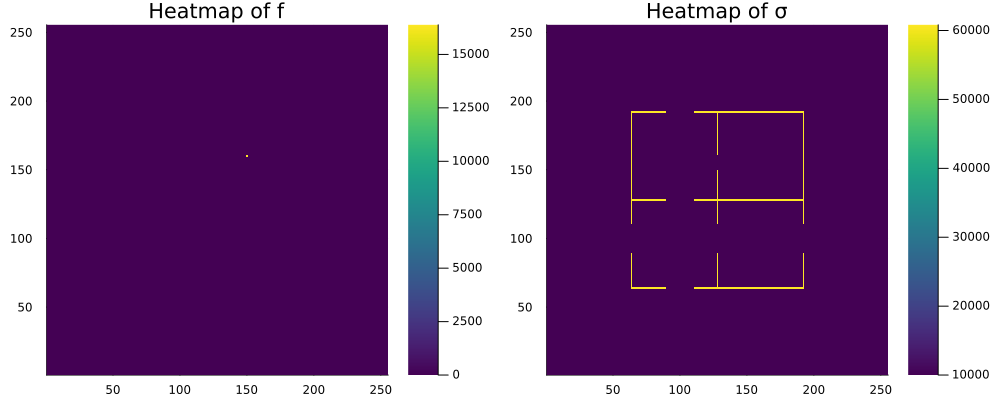

In [16]:
p1 = heatmap(reshape(f,length(grid),length(grid)), color=:viridis, title="Heatmap of f")
p2 = heatmap(reshape(abs.(σ),length(grid),length(grid)), color=:viridis, title="Heatmap of σ")
p = plot(p1, p2, layout = (1, 2), size = (1000, 400))

savefig(p, "../plots/wifi_setup.pdf")
display(p)

In [17]:
pre = nonuniform_preconditioner(; grid=grid, H=H_shifted, nu1=3,nu2=3)
S = Krylov.ktypeof(complex(float(f)))
global X = S[]  # Storage for GMRES iterates
gmres_callback(solver) = gmres_callbackX!(X,solver)

gmres_callback (generic function with 1 method)

In [18]:
X = S[]
presol, prestats = gmres(H, complex(float(f)), 
M=pre,
ldiv =false,
itmax = 500 ,
memory=500,
restart =true,
history=true,
callback =gmres_callback);
preres = [norm(H *x-f) for x in X];

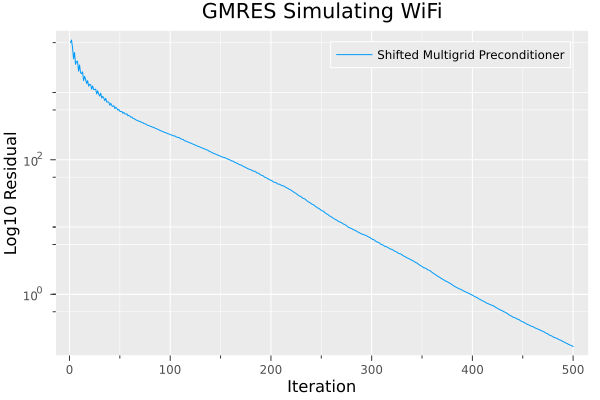

In [22]:
theme(:ggplot2)
p = plot(preres, yscale =:log10, label="Shifted Multigrid Preconditioner", title="GMRES Simulating WiFi", xlabel="Iteration", ylabel="Log10 Residual")
savefig(p, "../plots/gmres_wifi.pdf")
display(p)

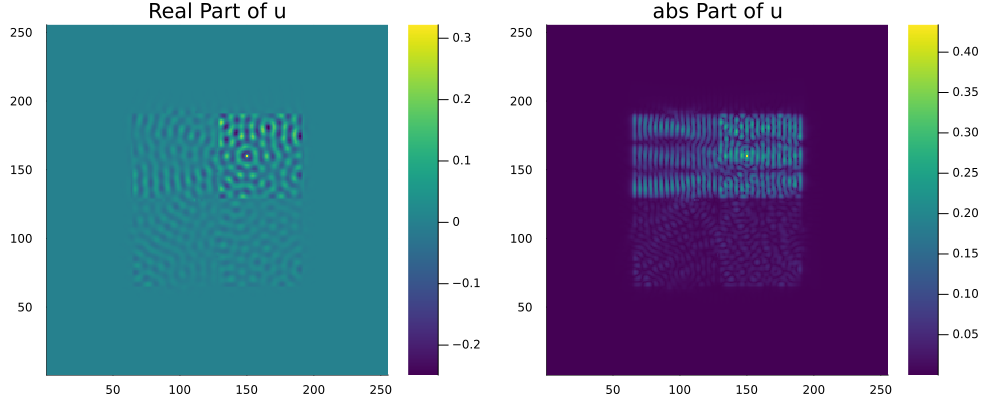

In [25]:
theme(:default)
z = reshape(presol, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="Real Part of u")
p2 = heatmap(abs.(z), color=:viridis, title="abs Part of u")

p = plot(p1, p2, layout = (1, 2), size = (1000, 400))
savefig(p, "../plots/gmres_wifi_solution.pdf")
display(p)